# Step 0. 필요한 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
mecab = Mecab()

# Step 1. 데이터 다운로드

In [2]:
file_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data'

data = pd.read_csv(file_path+'/ChatbotData.csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
questions = data['Q']
answers = data['A']

# Step 2. 데이터 정제

In [4]:
def preprocess_sentence(sentence):
    
    # 소문자로 치환
    sentence = sentence.lower()

    # 한글, 영어, 숫자, 구두점 외 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]", " ", sentence)
    
    return sentence

# Step 3. 데이터 토큰화

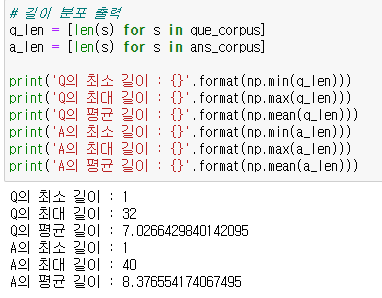

- 위 결과를 확인해 토큰 개수가 많지 않다는 인사이트를 얻음

    -> max_len을 지정해 일정 길이 이상인 데이터 제외를 하지 않을 것

In [5]:
def build_corpus(enc, dec):
    
    # 데이터 정제 및 토큰화
    mecab_enc_corpus = []
    mecab_dec_corpus = []

    for x in tqdm(enc, desc='소스 데이터 정제 및 토큰화'):
        clean_sentence = preprocess_sentence(x)
        mecab_enc_corpus.append(mecab.morphs(clean_sentence))

    for x in tqdm(dec, desc='타켓 데이터 정제 및 토큰화'):
        clean_sentence = preprocess_sentence(x)
        mecab_dec_corpus.append(mecab.morphs(clean_sentence))
    
    
    # 데이터프레임화
    df = pd.DataFrame({
        "Q": [' '.join(map(str, q)) for q in mecab_enc_corpus],  # 리스트 요소를 문자열로 변환
        "A": [' '.join(map(str, a)) for a in mecab_dec_corpus]   # 리스트 요소를 문자열로 변환
    })
    
    # 각 데이터 중복 제거 (리스트를 문자열로 변환 후 중복 제거)
    df.drop_duplicates(subset='Q', inplace=True)
    df.drop_duplicates(subset='A', inplace=True)
    
    # 중복 제거 후 다시 리스트로 변환
    que_corpus = [q.split() for q in df['Q']]  # 문자열을 다시 리스트로 변환
    ans_corpus = [a.split() for a in df['A']]  # 문자열을 다시 리스트로 변환
    
    return que_corpus, ans_corpus

In [6]:
# 데이터 정제 및 토큰화 수행
que_corpus, ans_corpus = build_corpus(questions, answers)

소스 데이터 정제 및 토큰화:   0%|          | 0/11823 [00:00<?, ?it/s]

타켓 데이터 정제 및 토큰화:   0%|          | 0/11823 [00:00<?, ?it/s]

In [7]:
print(len(que_corpus))
print(len(ans_corpus))

7674
7674


# Step 4. Augmentation

In [8]:
!pip install --upgrade gensim==3.8.3

In [9]:
from gensim.models import Word2Vec

def load_embeddings(filepath):
    model = Word2Vec.load(model_path)
    return model

def lexical_sub(sentence, model, topn=5):
    """
    주어진 문장에서 각 단어를 유사한 단어로 대체하여 새로운 문장 생성.
    :param sentence: 원본 문장 (list of tokens)
    :param model: Word2Vec 임베딩 모델
    :param topn: 대체 후보로 사용할 상위 유사 단어 개수
    :return: 대체된 단어로 구성된 문장
    """
    new_sentence = []
    
    for word in sentence:
        # 모델에 해당 단어가 있는지 확인
        if word in model.wv:
            # 해당 단어와 유사한 단어 리스트에서 무작위로 선택
            similar_words = model.wv.most_similar(word, topn=topn)
            substitute_word = random.choice(similar_words)[0]
            new_sentence.append(substitute_word)
        else:
            # 모델에 단어가 없으면 원본 단어 사용
            new_sentence.append(word)
    
    return new_sentence

# 한국어로 사전 훈련된 Embedding 모델 load
model_path = os.getenv('HOME') + '/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/Gd06/ko.bin'
model = load_embeddings(model_path)

aug_que_corpus = []
aug_ans_corpus = []

for x in tqdm(range(2), desc='데이터  증강중'):
    for sentence in tqdm(que_corpus, desc='소스 데이터 증강'):
        aug_que_corpus.append(lexical_sub(sentence, model))
    for sentence in tqdm(ans_corpus, desc='타켓 데이터 증강'):
        aug_ans_corpus.append(lexical_sub(sentence, model))

# 3배로 증강된 데이터셋을 질문과 답변을 나누어서 저장
augmented_que_corpus = (
    [aug_que for aug_que in aug_que_corpus] +
    [que for que in que_corpus] +
    [que for que in que_corpus]
)

augmented_ans_corpus = (
    [ans for ans in ans_corpus] +
    [aug_ans for aug_ans in aug_ans_corpus] +
    [ans for ans in ans_corpus]
)

데이터  증강중:   0%|          | 0/2 [00:00<?, ?it/s]

소스 데이터 증강:   0%|          | 0/7674 [00:00<?, ?it/s]

타켓 데이터 증강:   0%|          | 0/7674 [00:00<?, ?it/s]

소스 데이터 증강:   0%|          | 0/7674 [00:00<?, ?it/s]

타켓 데이터 증강:   0%|          | 0/7674 [00:00<?, ?it/s]

In [10]:
print(len(augmented_que_corpus))
print(len(augmented_ans_corpus))

30696
30696


# Step 5. 데이터 벡터화

In [11]:
# <start> 토큰과 <end> 토큰 추가

token_added_augmented_ans_corpus = []

for sentence in tqdm(augmented_ans_corpus, desc='타켓 데이터 <start> 토큰과 <end> 토큰 추기'):
    token_added_augmented_ans_corpus.append(["<start>"] + sentence + ["<end>"])

타켓 데이터 <start> 토큰과 <end> 토큰 추기:   0%|          | 0/30696 [00:00<?, ?it/s]

In [12]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [13]:
# 단어 사전 구축, 벡터화

corpus = []

for x in tqdm(range(len(augmented_que_corpus)), desc='데이터 통합'):
    corpus.append(augmented_que_corpus[x])
    
for x in tqdm(range(len(augmented_ans_corpus)), desc='데이터 통합'):
    corpus.append(token_added_augmented_ans_corpus[x])

#토큰화
corpus, tokenizer = tokenize(corpus)

# 통합한 데이터 분리
enc_train = corpus[:30696]
dec_train = corpus[30696:]

데이터 통합:   0%|          | 0/30696 [00:00<?, ?it/s]

데이터 통합:   0%|          | 0/30696 [00:00<?, ?it/s]

In [14]:
print(len(enc_train))
print(len(dec_train))

30696
30696


# Step 6. 훈련하기

Positional Encoding

In [15]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

마스크 생성

In [16]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

Multi-head Attention

In [17]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

Position-wise Feed Forward Network

In [18]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

Encoder Layer

In [19]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

Decoder Layer

In [20]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

Encoder

In [21]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

Decoder

In [22]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

Transformer 전체 모델 조립

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

Masking 정의

In [24]:
'''def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask'''

'def generate_padding_mask(seq):\n    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)\n    return seq[:, tf.newaxis, tf.newaxis, :]\n\ndef generate_causality_mask(src_len, tgt_len):\n    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)\n    return tf.cast(mask, tf.float32)\n\ndef generate_masks(src, tgt):\n    enc_mask = generate_padding_mask(src)\n    dec_enc_mask = generate_padding_mask(src)\n    dec_mask = generate_padding_mask(tgt)\n\n    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])\n    dec_mask = tf.maximum(dec_mask, dec_causality_mask)\n\n    return enc_mask, dec_enc_mask, dec_mask'

모델 인스턴스 생성

In [25]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
n_layers = 2
d_model = 1024
n_heads = 8
d_ff = 2048
src_vocab_size = tgt_vocab_size = len(tokenizer.word_index) + 1
pos_len = 256
dropout=0.3

transformer = Transformer(
    n_layers,
    d_model,
    n_heads,
    d_ff,
    src_vocab_size,
    tgt_vocab_size,
    pos_len,
    dropout,
    shared_fc=True,
    shared_emb=True)


Learning Rate Scheduler

In [26]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

Learning Rate & Optimizer

In [27]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

Loss Function 정의

In [28]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

Train Step 정의

In [29]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

번역 생성 함수

In [30]:
def decode_sequence(sequence):
    return ' '.join([tokenizer.index_word[index] for index in sequence if index in tokenizer.index_word])

In [31]:
def translate(tokens, model,tokenizer):
    max_len = 40
    
    tokens = preprocess_sentence(tokens)
    tokens = tokenizer.texts_to_sequences(tokens)
    
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                           maxlen=max_len,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tokenizer.word_index['<start>']], 0)   
    for i in range(max_len):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tokenizer.word_index['<end>'] == predicted_id:
            result = decode_sequence(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
        
    result = decode_sequence(ids)
    return result

훈련 진행

In [32]:
BATCH_SIZE = 128
EPOCHS = 20

model_list = []
result_list_lsit = []

examples = [
            "지루하다, 놀러가고 싶어.",
            "오늘 일찍 일어났더니 피곤하다.",
            "간만에 여자친구랑 데이트 하기로 했어.",
            "집에 있는다는 소리야."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    result_list = []
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list, desc=f'Epoch {epoch+1}/{EPOCHS}')

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in tqdm(examples,desc = '예문의 답변 생성중'):
        result = translate(example, transformer, tokenizer)
        result_list.append(result)
        
        print('Input: %s' % (example))
        print('Predicted translation: {}'.format(result))
        
    model_list.append(transformer.get_weights())
    result_list_lsit.append(result_list)

Epoch 1/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 은 은 듯 봐요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 기쁨 기쁨 않 않 않 으니
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 기쁨 역시 역시 이란 ㅂ시다 ...
Input: 집에 있는다는 소리야.
Predicted translation: 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니 아니


Epoch 2/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 좋 은 사람 들 이 에요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 저 도 좋 아 가 있 어요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 오늘 를 보 세요 .
Input: 집에 있는다는 소리야.
Predicted translation: 저 도 있 어요 .


Epoch 3/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 그럴 때 는 것 예요 는데
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 태현
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 나쁘 이란 나쁘 이란 나쁘 이란 나쁘 이란 나쁘 지요 ...
Input: 집에 있는다는 소리야.
Predicted translation: 저 는 편 이 에요 .


Epoch 4/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 어떡 들 을 해야 할 수 있 어요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 태현 때문 몇 아모리 해요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 나쁘 무수히 백만 해요 박영규
Input: 집에 있는다는 소리야.
Predicted translation: 저 는 편 이 아니 었 나 봐요 .


Epoch 5/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 널리 머물 봐요 는데
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 즐거운 장시간 수가 이루어지 더군요 는데
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 한 번 든 한 번 든 한 번 든 한 번 든 한 번 든 한 번 든 한 번 든 한 게 해요
Input: 집에 있는다는 소리야.
Predicted translation: 고향 그러하 ㄴ다 으므로 좋아지 이란 확정 그러 ㄴ다 들여다보 일일이 는데


Epoch 6/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 어찌 퀼 를 지키 는다는 포졸 를 지키 는다는 포졸 를 지키 아서요 는데
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 세요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 나쁘 이란 포졸 으로 ㄴ지요 ...
Input: 집에 있는다는 소리야.
Predicted translation: 저 는 편 이 아니 싶 었 으면 싶 는데요 으니


Epoch 7/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 그래도 야쓰시 때 보다 괜찮 아요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 간격 아니 바트 사루 수가 ㅂ니다 박영규
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 가슴 풀어쓰 나쁘 이란 뭐
Input: 집에 있는다는 소리야.
Predicted translation: 돈 이 아니 돈 이 에요 .


Epoch 8/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 죄인 아니 머물 는데 아쉽 아서요 으나
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 세요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 생각나 게끔 하고 게끔 하고 게끔 하고 게끔 해요 ...
Input: 집에 있는다는 소리야.
Predicted translation: 고향 그러하 안가 나쁘 이란 월과 그러하 ㅂ니까 ...


Epoch 9/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 그래도 슬프 네요 ...
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 간격 때문 분경 집시 이상
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 기의 게끔 갑자기 갑자기 ㅂ시다 ...
Input: 집에 있는다는 소리야.
Predicted translation: 다를 것 으므로 와 다를 것 예요 ...


Epoch 10/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 부끄러운 감정 이 어떡 할 때 보다 그래요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 간격 때문 있다 사루 봐요 박영규
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 자세히 놀 일일이 으나
Input: 집에 있는다는 소리야.
Predicted translation: 좋아지 이란 월과 그러하 ㅂ니까 는데


Epoch 11/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 때론 정확히 밝혀 봐요 는데
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 코리 유혹 잦 ㅂ니다 으나
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 시키 게끔 시키 지만 영혼 으로 있다 는데요 박영규
Input: 집에 있는다는 소리야.
Predicted translation: 바구니 내기 다를 것 비슷 므로 바구니 내기 다를 것 비슷 구요 는데


Epoch 12/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 바쁜가 봐요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 못 자 세요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 지금 은 우세요 .
Input: 집에 있는다는 소리야.
Predicted translation: 돈 은 아름답 므로 나쁘 싶 네요 .


Epoch 13/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 구축 으로 으므로 당신 구축 으로 아서요 으나
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 간격 아니 있음 타 머지않 타 봐요 박영규
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 생각나 기 도 하 겠 어요 .
Input: 집에 있는다는 소리야.
Predicted translation: 제 한테 라면 고향 로도 다를 것 같 아요 .


Epoch 14/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 그래도 사랑 할 수 있 죠 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 제 가 드리 고 싶 네요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 설정 한두 사실 으로 았 타 봐요 ...
Input: 집에 있는다는 소리야.
Predicted translation: 좋 은 결정 이 아니 에요 .


Epoch 15/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 살아가 거든요 는데 멋지 어도 나쁘 구요 는데
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 간격 그렇 있음 였 나의 봅니다 는데
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 생각나 갑자기 생각나 갑자기 생각나 갑자기 생각나 갑자기 생각나 ㅂ시다
Input: 집에 있는다는 소리야.
Predicted translation: 집이 줌 므로 나쁘 었 군요 는데


Epoch 16/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 귀찮 봐요 으나
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 나쁜 분 에게 물 어 보 세요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 생각나 기 도 해요 .
Input: 집에 있는다는 소리야.
Predicted translation: 다섯 찾아가 들여다보 므로 그리울 말로 아니 ㄴ지요 으나


Epoch 17/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 때론 은 때론 노력 하 는 사람 인가 봐요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 좀더 던 펠 것 예요
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 만남 꾀하 게끔 만남 으로서 만남 한두 무척 만남 으로서 만남 으로서 용이 해요 ...
Input: 집에 있는다는 소리야.
Predicted translation: 제 그럼 오자키 ...


Epoch 18/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 색다른 걸 어 보 세요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 좀 더 찾 ㅂ시오 ...
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 생각나 게 사 는 게 갑자기 생각나 세요 .
Input: 집에 있는다는 소리야.
Predicted translation: 저 에게 받 고 싶 은 위 로 만들 어 에게 좋 은 거 같 아요 .


Epoch 19/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 색다른 걸 드셔 보 세요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 만 있 어도 만 있 습니다 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 잊어버리 ㅂ시오
Input: 집에 있는다는 소리야.
Predicted translation: 마요 ...


Epoch 20/20:   0%|          | 0/240 [00:00<?, ?it/s]

예문의 답변 생성중:   0%|          | 0/4 [00:00<?, ?it/s]

Input: 지루하다, 놀러가고 싶어.
Predicted translation: 어떡 시키 아서 좋아지 예기 모르 네요 으나
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 잘 모르 고 있 는 만 해요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 갑자기 읽 ㅂ시오 박영규
Input: 집에 있는다는 소리야.
Predicted translation: 집이 주위 것들 오자키 캐치


# Step 7. 성능 측정하기

In [33]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

In [34]:
def eval_bleu_single(src, tgt):
    max_len = 40
    
    src = preprocess_sentence(src)
    src_seq = tokenizer.texts_to_sequences([src])  # 리스트로 감싸줍니다
    
    src_seq = tf.keras.preprocessing.sequence.pad_sequences(src_seq,
                                                            maxlen=max_len,
                                                            padding='post')
    
    tgt = preprocess_sentence(tgt)
    tgt_seq = tokenizer.texts_to_sequences([tgt])  # 리스트로 감싸줍니다
    
    tgt_seq = tf.keras.preprocessing.sequence.pad_sequences(tgt_seq,
                                                            maxlen=max_len,
                                                            padding='post')
    
    # numpy.ndarray를 다시 리스트로 변환하여 BLEU 계산
    src_seq_list = src_seq.tolist()[0]
    tgt_seq_list = tgt_seq.tolist()[0]

    score = sentence_bleu([src_seq_list], tgt_seq_list,
                          smoothing_function=SmoothingFunction().method1)
    
    return score

In [35]:
def eval_bleu(src_sentences, tgt_sentence):
    
    for x in tqdm(range(len(src_sentences))):
        blue = eval_bleu_single(src_sentences[x], tgt_sentence[x])
        print("target data: ", src_sentences[x])
        print("pred: ", tgt_sentence[x])
        print("blue score: ", blue)

In [38]:
target = [
            "잠깐 쉬 어도 돼요 .",
            "맛난 거 드세요 .",
            "떨리 겠 죠 .",
            "좋 아 하 면 그럴 수 있 어요 ."
]

pred = result_list_lsit[13]

eval_bleu(target, pred)

  0%|          | 0/4 [00:00<?, ?it/s]

target data:  잠깐 쉬 어도 돼요 .
pred:  그래도 사랑 할 수 있 죠 .
blue score:  0.8440120604870561
target data:  맛난 거 드세요 .
pred:  제 가 드리 고 싶 네요 .
blue score:  0.8440120604870561
target data:  떨리 겠 죠 .
pred:  갑자기 설정 한두 사실 으로 았 타 봐요 ...
blue score:  0.7660061645363807
target data:  좋 아 하 면 그럴 수 있 어요 .
pred:  좋 은 결정 이 아니 에요 .
blue score:  0.7981256013410023


# 회고

예전 부터 관심 있었던 대화형 챗봇을 드디어 해보니 좋은것 같다.

하지만 성능 자체는 좋지않아 데이터를 늘리면 조금은 성능이 좋아지겠지 라는 생각을 해본다.